In [19]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc, precision_score
import scipy.stats

import seaborn as sns
from MutBkgd import MutationBackground

%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

In [20]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999; 

<IPython.core.display.Javascript object>

In [21]:
prefix = 'HIS.'

folder_prefix = '0731_46fea_newHJRate_weight-1' # remember to create new folder for new sets of ROC and enrichment figure
#folder_prefix = 'test'


In [22]:
import os, errno

try:
    os.makedirs('/home/local/ARCS/hq2130/missense/'+folder_prefix+'_ROC_figure')
    os.makedirs('/home/local/ARCS/hq2130/missense/'+folder_prefix+'_enrich_figure')
    print "folder created!"
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

In [23]:

s_het = np.load('../data/gene/s_het.npy').item()
prec = np.load('../data/gene/prec.npy').item()
pli = np.load('../data/gene/pli.npy').item()
lofz = np.load('../data/gene/lofz.npy').item()

HS_gene = set(gene for gene, pli_score in pli.iteritems() if pli_score < 0.5)
HIS_gene = set(gene for gene, pli_score in pli.iteritems() if pli_score >= 0.5)
prec_5 = set(gene for gene, pli_score in prec.iteritems() if pli_score >0.5)
lofz3 = set(gene for gene, score in lofz.iteritems() if score >= 3)

if prefix == 'HIS.':
    geneset = HIS_gene 
elif prefix == 'HS.':
    geneset = HS_gene
elif prefix == 'All.':
    geneset = HS_gene | HIS_gene
else:
    geneset = geneset

# compare confusion matrix

In [24]:
def plot_multi_confusion_matrix(df, y_true, dataset, save=False,
                                class_names = ['damage_negative', 'damage_positive']):
    '''take a dataframe with predictors and y_true value, output multiple confusion matrix plot
    '''
    
    # 'M-CAP_rankscore', 0.4815 is 0.025 cutoff 0.642 is 0.05 cutoff 
    col_dict={'cadd15':('CADD_phred', 15), 'cadd18':('CADD_phred', 18),
              'cadd20':('CADD_phred', 20), 'cadd22':('CADD_phred', 22),
              'cadd24':('CADD_phred', 24), 'cadd26':('CADD_phred', 26),
              'cadd28':('CADD_phred', 28), 'cadd30':('CADD_phred', 30),
              'eigen_pred10':('Eigen-phred', 10), 'eigen_pred15':('Eigen-phred', 15),
              'eigen_pc_pred10':('Eigen-PC-phred', 10),
              'MetaSVM>0':('MetaSVM_rankscore', 0.82271),'MetaLR>0':('MetaLR_rankscore', 0.81122),
              'M_CAP>0.025':('M-CAP_rankscore', 0.4815), 'M_CAP>0.05':('M-CAP_rankscore', 0.642),
              'PP2-HVAR':('Polyphen2_HVAR_rankscore', 0.6280),'FATHMM':('FATHMM_converted_rankscore', 0.8235),
              'all_missense':('cnn_prob', 0.0),'cnn_0.05':('cnn_prob', 0.05),
              'cnn_0.1':('cnn_prob', 0.1), 'cnn_0.2':('cnn_prob', 0.2),
              'cnn_0.3':('cnn_prob', 0.3), 'cnn_0.4':('cnn_prob', 0.4),
              'cnn_0.5':('cnn_prob', 0.5), 'cnn_0.6':('cnn_prob', 0.6),
              'cnn_0.7':('cnn_prob', 0.7), 'cnn_0.8':('cnn_prob', 0.8),
              'cnn_best_0.56':('cnn_prob', 0.56),
              'revel_0.4':('REVEL',0.4),'revel_0.5':('REVEL',0.5),
              'revel_0.6':('REVEL',0.6),'revel_0.7':('REVEL',0.7),'revel_0.8':('REVEL',0.8),
              'revel_0.9':('REVEL',0.9),
              'mpc_1':('MPC',1),'mpc_1':('MPC',2)}
    
    y_preds, y_algos = [], []
    for key, (col, threshold) in col_dict.items():
        y_algos.append(key)
        y_preds.append(convert2binary(df, col, threshold))

    infos = []
    for y_pred, y_algo in zip(y_preds, y_algos):
        # Compute confusion matrix
        accuracy = accuracy_score(y_true, y_pred)# y_true <=target(true label)= 1 or 0 , y_pred = 1 or 0 depends on method and threshold
        f1 = f1_score(y_true, y_pred)
        cnf_matrix = confusion_matrix(y_true, y_pred)
        fdr = 1 - precision_score(y_true, y_pred)
        np.set_printoptions(precision=2)

        title = '../ccfigure/' + dataset + y_algo + '.png'
        # Plot non-normalized confusion matrix
        figure_title = 'Confusion matrix, without normalization\n{}\n{}\n accuracy: {:.2f}\n f1: {:.2f}\n'.format(
            dataset, y_algo, accuracy, f1)
        fig = plt.figure(figsize = (5,5))
        plot_confusion_matrix(cnf_matrix, classes=class_names,
                              title=figure_title)
        
        if save: # now default is not save!
            infos.append([y_algo, accuracy, f1, fdr])
            fig.savefig(title)
            plt.close()
        else:
            plt.show()
    labels = ['Col', 'accuracy', 'f1', 'FDR']            
    df = pd.DataFrame(infos,columns=labels)
    display(df)

def convert2binary(df, col, threshold):
    '''take a dataframe, col to compare, threshold, return the binary vector
        convert to more elegent lambda function way 
        http://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
    '''
    values = np.array(df[col].values)
    values = values[~np.isnan(values)] # remove NA
    index = values >= threshold
    values[index] = 1
    values[~index] = 0
    return values

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=45)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
# class_names = ['damage_negative', 'damage_positive'] # 0 for 'damage_negative', 1 for 'damage_positive'

# validation = '../data/output/output_data_mode5.cnn.csv'# validation is 20% of DNM not used in training and testing
# fname = validation
# df = pd.read_csv(fname)
# df = df[df.training==0]
# y_true = df.pop('target')
# dataset = 'validation(20% HGMD,DiscovEHR)'
# #plot_multi_confusion_matrix(df, y_true, dataset, save=True)

In [26]:

#fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.'+prefix+'reformat.cnn.csv', # teacher7's old score using wrong GC
#          '../data/metaSVM/metaSVM_test2.anno.rare.'+prefix+'reformat.cnn.csv',
#          '../data/metaSVM/metaSVM_addtest1.anno.rare.'+prefix+'reformat.cnn.csv',
#          '../data/metaSVM/metaSVM_addtest2.anno.rare.'+prefix+'reformat.cnn.csv',
#          '../data/metaSVM/metaSVM_train.anno.rare.'+prefix+'reformat.cnn.csv']

# fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.'+prefix+'reformat.GCcorrected.cnn.csv', # cc's brand new score using correct GC
#           '../data/metaSVM/metaSVM_test2.anno.rare.'+prefix+'reformat.GCcorrected.cnn.csv',
#           '../data/metaSVM/metaSVM_addtest1.anno.rare.'+prefix+'reformat.GCcorrected.cnn.csv',
#           '../data/metaSVM/metaSVM_addtest2.anno.rare.'+prefix+'reformat.GCcorrected.cnn.csv',
#           '../data/metaSVM/metaSVM_train.anno.rare.'+prefix+'reformat.GCcorrected.cnn.csv']

# for fname in fnames:
#     df = pd.read_csv(fname)
#     y_true = df.pop('target')
#     dataset = fname.split('_')[-1].split('.')[0]
#     print dataset
#     plot_multi_confusion_matrix(df, y_true, dataset, save=True)


# ROC

In [27]:
## cc's new function for roc curve 
## specify font size!!!
import matplotlib.font_manager as font_manager

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Helvetica', 'size':'22', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Helvetica', 'size':'22'}

# Set the font properties (for use in legend)   
font_path = '../../Helvetica-Regular.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=22)

'''
ax = plt.subplot() # Defines ax variable by creating an empty plot

# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
'''

def plot_roc(df, y_true, label):
    
    #### change color for curves ## tried but failed
    #num_plots = 13

    ## Have a look at the colormaps here and decide which one you'd like:
    ## http://matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html
    #colormap = plt.cm.gist_ncar
    #plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])
    
    cpool = [ '#000000', '#bbb12d', '#1480fa', '#bd2309',
              '#2edfea', '#ea2ec4', '#ea2e40', 'gold',#'lightgreen',#'#cdcdcd',
              '#577a4d',  '#f59422', '#2e46c0','#219774', 'purple']#'#8086d9' ]
    
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    algos = ['cnn_prob', 'MetaSVM_rankscore', 'MetaLR_rankscore', 'M-CAP_rankscore', 
             'DANN_rankscore','CADD_phred', 'Eigen-phred','Polyphen2_HVAR_rankscore', 
             'MutationTaster_converted_rankscore', 'FATHMM_converted_rankscore', 
             'fathmm-MKL_coding_rankscore','REVEL', 'MPC']
    
    color_dict = {'cnn_prob':cpool[0], 'MetaSVM_rankscore':cpool[1], 'MetaLR_rankscore':cpool[2],
              'M-CAP_rankscore':cpool[3], 'DANN_rankscore':cpool[4],'CADD_phred':cpool[5],
              'Eigen-phred':cpool[6],'Polyphen2_HVAR_rankscore':cpool[7], 
              'MutationTaster_converted_rankscore':cpool[8],
              'FATHMM_converted_rankscore':cpool[9], 
              'fathmm-MKL_coding_rankscore':cpool[10],
              'REVEL':cpool[11], 
              'MPC':cpool[12]}
        
    for algo in algos:
        index = (df[algo].notnull()) & (df[algo]!= -1) & (df[algo]!= 0) 
        y_score = df.ix[index][algo].values
        y_true_nomissing = y_true[index]

        fpr[algo], tpr[algo], _ = roc_curve(y_true_nomissing, y_score)
        roc_auc[algo] = auc(fpr[algo], tpr[algo])
    # jump comes from missing value

    plt.figure(figsize = (10,10))
    lw = 1.5
    for idx, algo in enumerate(algos):
        newalgo = algo.replace('cnn','MVP')
        plt.plot(fpr[algo], tpr[algo], lw=lw, 
                 label='{} (area = {:.3f})'.format(newalgo.split('_')[0], roc_auc[algo]),
                 color =color_dict[algo])

        plt.plot([0, 1], [0, 1], color='Navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate',**axis_font)
        plt.ylabel('True Positive Rate',**axis_font)
        
    total = len(y_true)
    pos = sum(y_true)
    neg = total - pos
    
    plt.title('ROC of {}:\n {} positive, {} negative'.format(label, pos, neg),**title_font)
    plt.legend(loc="lower right", fontsize = '14')
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    #plt.show()
    #plt.savefig('../ROC_figure/ROC_'+label+'_dpi600.eps', format='eps', dpi=1200)
    
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters based on distance
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'dist' : pd.Series(abs(tpr-fpr), index=i), 'threshold' : pd.Series(threshold, index=i),
                        'fpr':pd.Series(fpr, index=i), 'tpr':pd.Series(tpr, index=i)})
    roc_t = roc.ix[roc.dist.argsort()]
    return roc_t.tail(3)

In [28]:
# ignore validaiton part
# class_names = ['damage_negative', 'damage_positive']
# fname = validation
# df = pd.read_csv(fname)
# y_true = df.pop('target')
#plot_roc(df, y_true, label = 'validation')
#Find_Optimal_Cutoff(y_true, df['cnn_prob'])

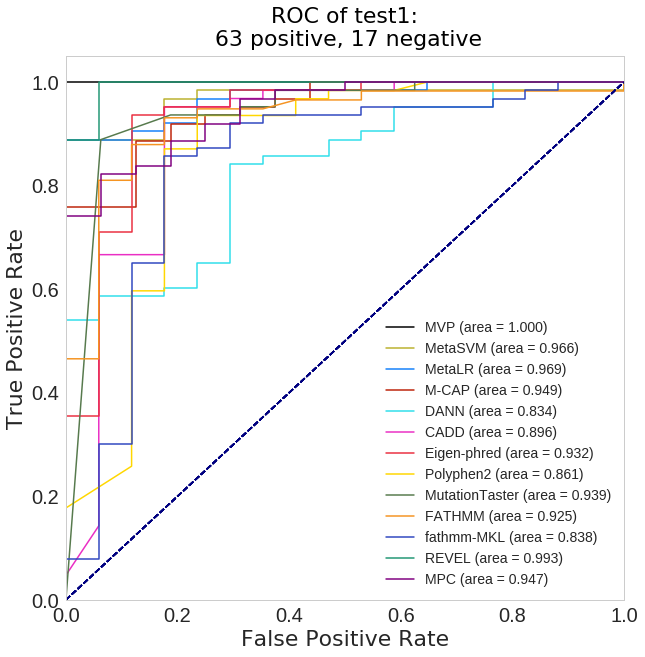

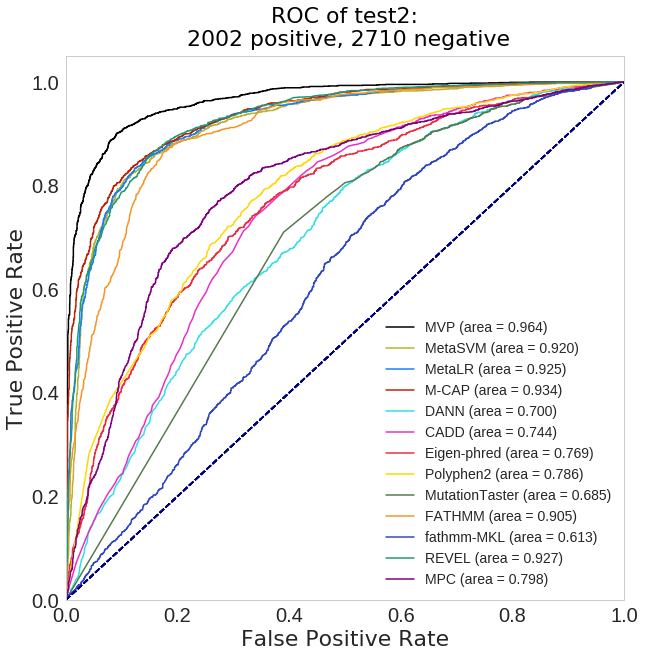

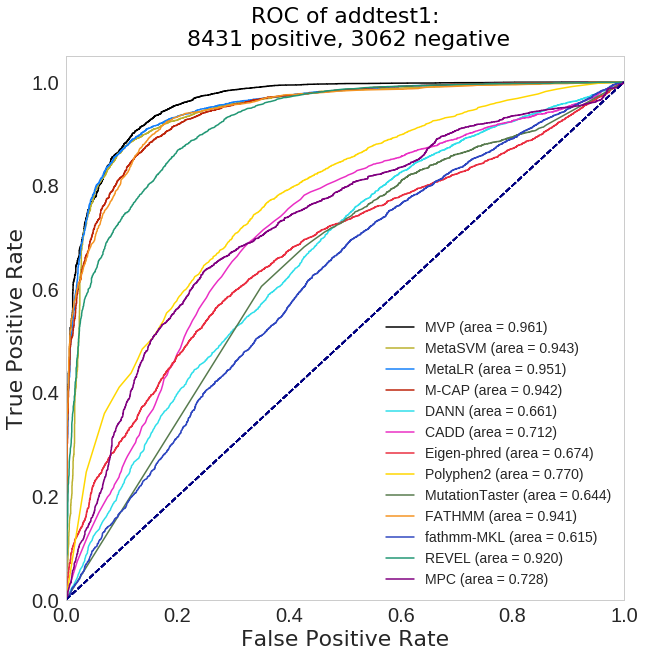

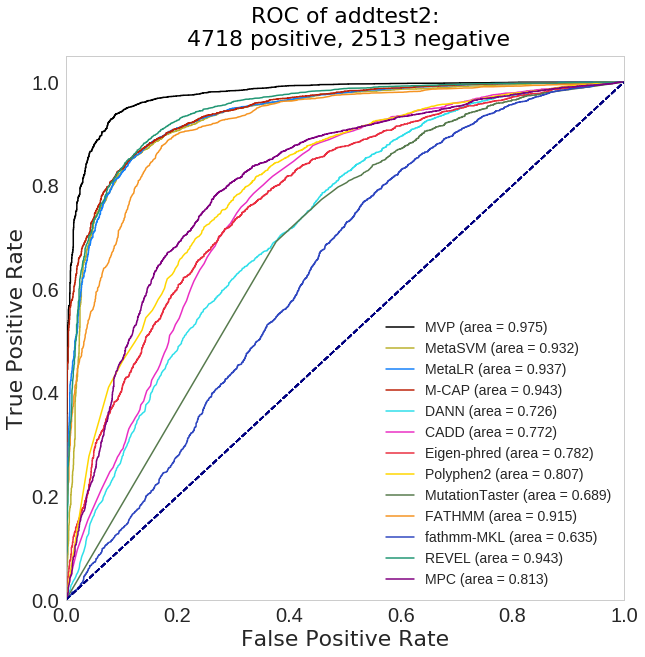

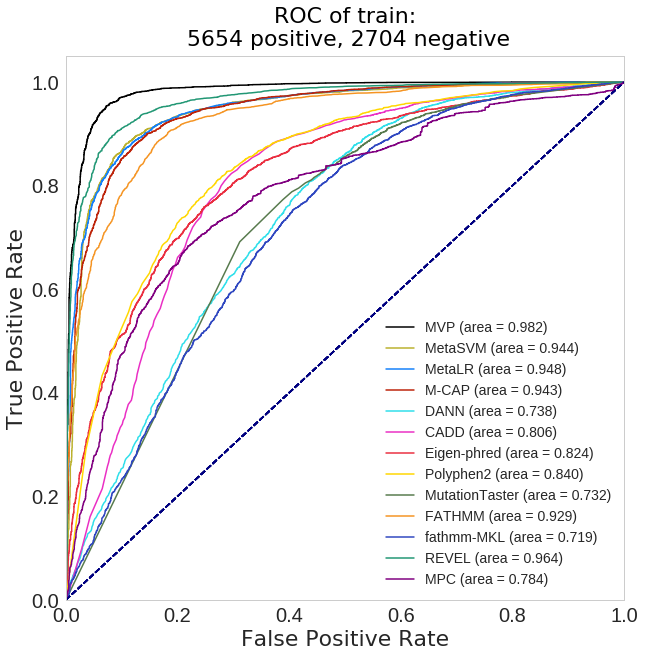

In [29]:
# metaSVM test
#fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.'+prefix+'reformat.cnn.csv', # teacher7's old score using wrong GC
#          '../data/metaSVM/metaSVM_test2.anno.rare.'+prefix+'reformat.cnn.csv',
#          '../data/metaSVM/metaSVM_addtest1.anno.rare.'+prefix+'reformat.cnn.csv',
#          '../data/metaSVM/metaSVM_addtest2.anno.rare.'+prefix+'reformat.cnn.csv',
#          '../data/metaSVM/metaSVM_train.anno.rare.'+prefix+'reformat.cnn.csv']

fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.'+prefix+'reformat.cnn.csv', # cc's brand new score using correct GC
          '../data/metaSVM/metaSVM_test2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_train.anno.rare.'+prefix+'reformat.cnn.csv']

labels = []
for fname in fnames:
    labels.append(fname.split('_')[-1].split('.')[0])
    
for fname, label in zip(fnames, labels):
    df = pd.read_csv(fname)
    y_true = df.pop('category')
    index = y_true == 'TP'
    y_true[index] = 1
    y_true[~index] = 0
    y_true = y_true.astype(int)
    plot_roc(df, y_true, label)
    plt.savefig('../'+folder_prefix+'_ROC_figure/ROC_'+prefix+'_'+label+'_dpi1200.eps', format='eps', dpi=1200)
    #plt.savefig('methcomp+revel_'+fname.split('_')[-1].split('.')[0]+".eps", bbox_inches='tight') file not found!

# test among clivar/UniFun from papers

In [30]:

# # metaSVM test
# fnames = ['../data/paper_test/ClinVar.anno.rare.' + prefix + 'reformat.cnn.csv', 
#           '../data/paper_test/UniFun.anno.rare.' + prefix + 'reformat.cnn.csv']
# labels = []
# for fname in fnames:
#     labels.append(fname.split('_')[-1].split('.')[0])
    
# for fname, label in zip(fnames, labels):
#     df = pd.read_csv(fname)
#     y_true = df.pop('category')
#     index = y_true == 'TP'
#     y_true[index] = 1
#     y_true[~index] = 0
#     y_true = y_true.astype(int)
#     plot_roc(df, y_true, label)
#     #plt.savefig('methcomp+revel_'+fname.split('_')[-1].split('.')[0]+".png", bbox_inches='tight') file not found!


# cancer hotspot among oncogene / TS genes

5446
208
153
61
12766


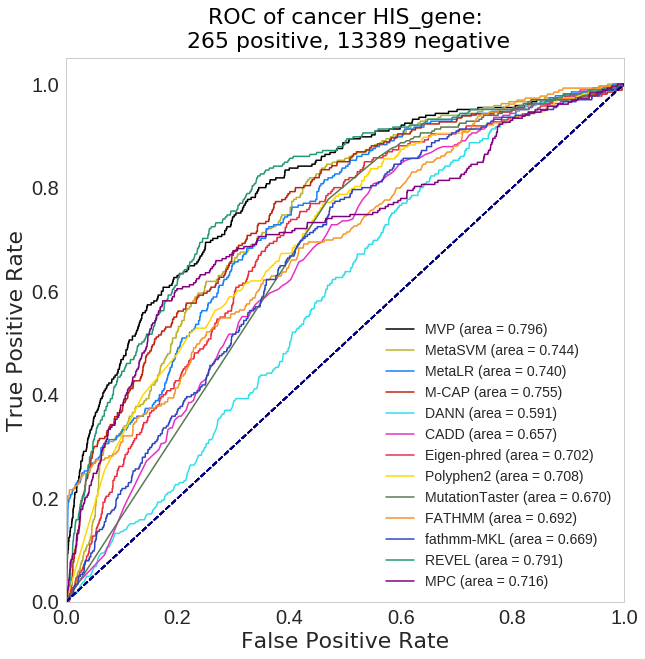

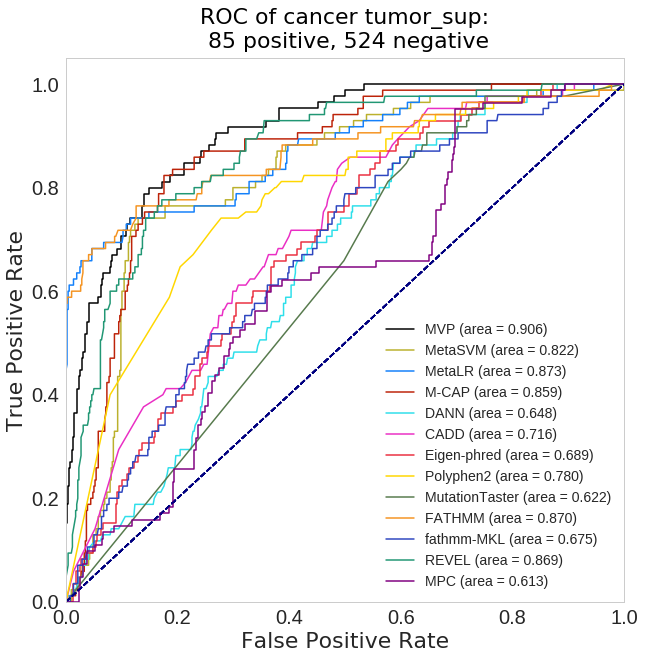

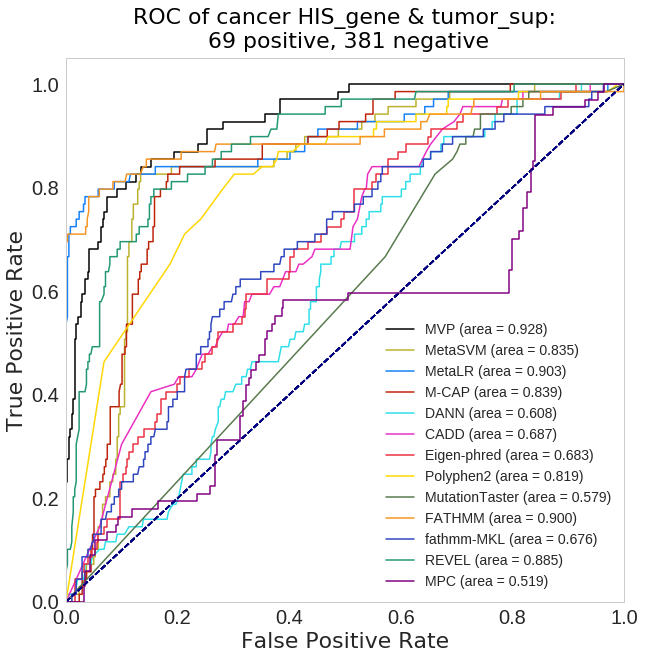

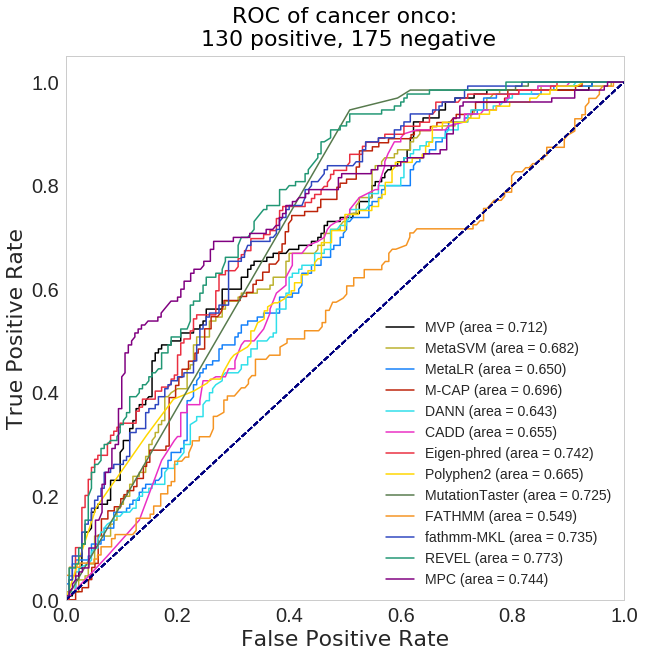

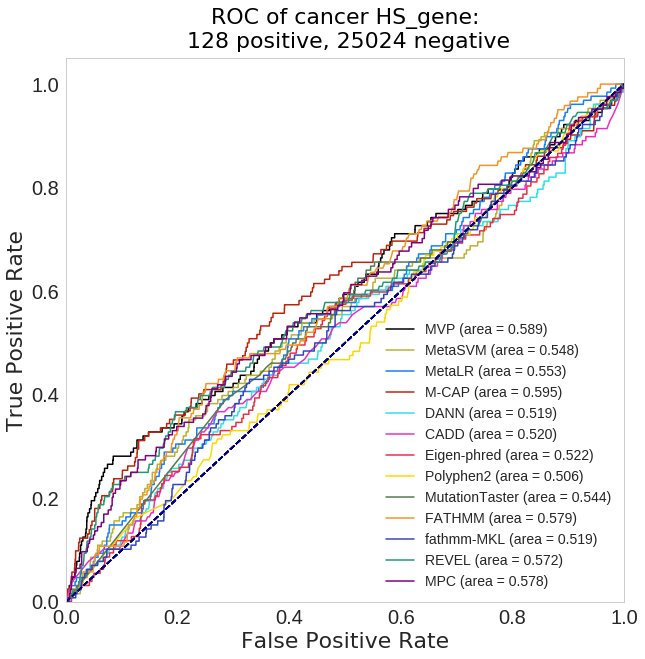

In [31]:
class_names = ['cancer_passengers', 'cancer_hotspot']
fname = '../data/cancer_hotspots/cancer_sel.HIS.reformat.cnn.csv' # teacher7 old wrong GC
#fname = '../data/cancer_hotspots/cancer_sel.HIS.reformat.GCcorrected.cnn.csv'
cancer_HIS = pd.read_csv(fname)
#fname = '../data/cancer_hotspots/cancer_sel.HS.reformat.cnn.csv' # teacher7 old wrong GC
fname = '../data/cancer_hotspots/cancer_sel.HS.reformat.cnn.csv'
cancer_HS = pd.read_csv(fname)
cancer= pd.concat([cancer_HIS, cancer_HS], ignore_index=True)

with open('../data/gene/oncogenes.txt') as f:
    onco = set(line.strip() for line in f.readlines())

with open('../data/gene/tumor_sup.txt') as f:
    tumor_sup = set(line.strip() for line in f.readlines())

cancer_genesets = [HIS_gene, tumor_sup, HIS_gene & tumor_sup, onco, HS_gene]
cancer_genesets_label = ['HIS_gene', 'tumor_sup', 'HIS_gene & tumor_sup', 'onco', 'HS_gene']
for idx, cancer_geneset in enumerate(cancer_genesets):
    print len(cancer_geneset)
    index =  cancer['genename'].isin(cancer_geneset) 
    tmp = cancer[index]
    y_true = tmp.target
    plot_roc(tmp, y_true, label = 'cancer ' + cancer_genesets_label[idx])
    plt.savefig('../'+folder_prefix+'_ROC_figure/ROC_cancer'+cancer_genesets_label[idx]+'_dpi1200.eps', format='eps', dpi=1200)
    #plt.savefig('methcomp+revel_'+'cancer'+cancer_genesets_label[idx], bbox_inches='tight')

# enrichment

In [32]:
## avoid overlapping labels
from adjustText import adjust_text

## specify font size!!
import matplotlib.font_manager as font_manager

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Helvetica', 'size':'22', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Helvetica', 'size':'22'}

# Set the font properties (for use in legend)   
font_path = '../../Helvetica-Regular.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=22)

In [33]:
fname = '../data/gene/mis_rate_na0726_filtered.txt' 
#fname = '../data/gene/mis_rate_HJ0725_AF10-5_filtered.txt'
#fname = '../data/gene/mis_rate_hongjian_one_gene0617.txt'

mutation_bkgrd = MutationBackground(fname)


def display_enrichment(case_info, control_info, case_disease, geneset, sort_key='Col'):
    
    print case_disease
    df_case, case_disease, disease_size = case_info 
    df_control, control_disease, disease_size = control_info 
    
    # recurrent variants only count once
#     df_case = df_case.drop_duplicates(subset='var_id').reset_index()
#     df_control = df_control.drop_duplicates(subset='var_id').reset_index()
    
    
    case_size = 0.0
    for disease in case_disease:
        if disease in disease_size:
            case_size += disease_size[disease]
    control_size = 0.0
    for disease in control_disease:
        control_size += disease_size[disease]
    print 'case size:{} control size:{}'.format(case_size, control_size)
    
    # 'M-CAP_rankscore', 0.4815 is 0.025 cutoff 0.642 is 0.05 cutoff
    col_dict={'cadd15':('CADD_phred', 15), 'cadd18':('CADD_phred', 18),
              'cadd20':('CADD_phred', 20), 'cadd22':('CADD_phred', 22),
              'cadd24':('CADD_phred', 24), 'cadd26':('CADD_phred', 26),
              'cadd28':('CADD_phred', 28), 'cadd30':('CADD_phred', 30),
              'eigen_pred10':('Eigen-phred', 10), 'eigen_pred15':('Eigen-phred', 15),
              'eigen_pc_pred10':('Eigen-PC-phred', 10), 
              'MetaSVM>0':('MetaSVM_rankscore', 0.82271),'MetaLR>0':('MetaLR_rankscore', 0.81122), 
              'M_CAP>0.025':('M-CAP_rankscore', 0.4815), 'M_CAP>0.05':('M-CAP_rankscore', 0.642), 
              'PP2-HVAR':('Polyphen2_HVAR_rankscore', 0.6280),'FATHMM':('FATHMM_converted_rankscore', 0.8235),
              'all_missense':('cnn_prob', 0.0),'cnn_0.05':('cnn_prob', 0.05),
              'cnn_0.1':('cnn_prob', 0.1), 'cnn_0.2':('cnn_prob', 0.2),
              'cnn_0.3':('cnn_prob', 0.3), 'cnn_0.4':('cnn_prob', 0.4),
              'cnn_0.5':('cnn_prob', 0.5), 'cnn_0.6':('cnn_prob', 0.6),
              'cnn_0.7':('cnn_prob', 0.7), 'cnn_0.8':('cnn_prob', 0.8),
              'cnn_best_0.56':('cnn_prob', 0.56),
              'revel_0.4':('REVEL',0.4),'revel_0.5':('REVEL',0.5),
              'revel_0.6':('REVEL',0.6),'revel_0.7':('REVEL',0.7),'revel_0.8':('REVEL',0.8),
              'revel_0.9':('REVEL',0.9)}
    
    col_dict={'cadd15':('CADD_phred', 15), 
              'cadd20':('CADD_phred', 20), 
              'cadd25':('CADD_phred', 25), 'cadd30':('CADD_phred', 30),
              #'eigen_pred10':('Eigen-phred', 10), 'eigen_pred15':('Eigen-phred', 15),
              #'eigen_pc_pred10':('Eigen-PC-phred', 10), 
              'MetaSVM>0':('MetaSVM_rankscore', 0.82271),'MetaLR>0':('MetaLR_rankscore', 0.81122), 
              'M_CAP>0.025':('M-CAP_rankscore', 0.4815), 'M_CAP>0.05':('M-CAP_rankscore', 0.642), 
              'PP2-HVAR':('Polyphen2_HVAR_rankscore', 0.6280),'FATHMM':('FATHMM_converted_rankscore', 0.8235),
              'all_missense':('cnn_prob', -1),'cnn_0.05':('cnn_prob', 0.05),
              'cnn_0.1':('cnn_prob', 0.1), 'cnn_0.2':('cnn_prob', 0.2),
              'cnn_0.3':('cnn_prob', 0.3), 'cnn_0.4':('cnn_prob', 0.4),
              'cnn_0.5':('cnn_prob', 0.5), 'cnn_0.6':('cnn_prob', 0.6),
              'cnn_0.7':('cnn_prob', 0.7), 'cnn_0.8':('cnn_prob', 0.8),'cnn_0.9':('cnn_prob', 0.9),
              'MPC>1':('MPC', 1), 'MPC>2':('MPC', 2),
              'revel_0.5':('REVEL',0.5),
              'revel_0.6':('REVEL',0.6),'revel_0.7':('REVEL',0.7),'revel_0.8':('REVEL',0.8),
              'revel_0.9':('REVEL',0.9)}

    
    infos = [] 
    for col_name, (col, threshold) in col_dict.items():
        case_count = np.sum(convert2binary(df_case, col, threshold))
        control_count = np.sum(convert2binary(df_control, col, threshold))
        control_count = max(control_count, 1) # default for 0 control
        
        total_counts = case_count + control_count

        case_rate = float(case_count) / case_size
        control_rate = float(control_count) / control_size
        enrich =  case_rate / ( control_rate * syn_ratio[case_disease[0]])
        pvalue = scipy.stats.binom_test(case_count, 
                                        total_counts,
                                        case_size / (case_size + control_size)) ## use raw control counts here
        #enrich = max(enrich, 1) # do not plot if enrich <1, tpr <0, risk_gene <0
        tpr = (enrich - 1) / enrich
        risk_gene = case_count * tpr
        
        
        exp = mutation_bkgrd.expectation(geneset, col_name) * case_size 
        if exp == 0: # use control instead
            print "bkgrd rate = 0, use control instead"
            exp = case_count - risk_gene
            
        bk_adjust = 1 #syn_ratio[case_disease[0]] #* 1.208321
        #exp_enr = max(case_count / exp / bk_adjust , 1) # do not plot if enrich <1, tpr <0, risk_gene <0
        exp_enr = case_count / exp / bk_adjust 
        exp_tpr = (exp_enr - 1) / exp_enr
        exp_risk_gene = case_count * exp_tpr
        
        infos.append([col_name, case_count, control_count, 
                      enrich, pvalue, risk_gene, tpr,
                      exp, exp_enr, exp_risk_gene, exp_tpr])
        
    
    labels = ['Col', 'Case', 'Control', 'enrich', 'pvalue', '# risk gene', 'true positive rate',
              'exp', 'exp_enr', 'exp_risk_gene', 'exp_tpr']            
    df = pd.DataFrame(infos,columns=labels)
    df = df.sort_values(by=sort_key, ascending=True)
    display(df)
    df.to_csv('../'+folder_prefix+'_enrich_figure/'+prefix+case_disease[0]+'.csv', sep='\t')
    plot_rate_vs_riskvariants(df, case_disease[0], vs_bkg=False)
    plot_rate_vs_riskvariants(df, case_disease[0], vs_bkg=True)
    return df

def plot_rate_vs_riskvariants(df, title,  vs_bkg):
    
    ## control font size for all txt in figure
    font = {'family' : 'Helvetica',
            'weight' : 'normal',#bold
            'size'   : 16}

    #matplotlib.rc('font', **font)

    y = list(df['true positive rate'])
    ymin, ymax = min(y), max(y)
    
    x = list(df['# risk gene'])
    
    if vs_bkg:
        y = list(df['exp_tpr'])
        x = list(df['exp_risk_gene'])
    
    z = list(df['Col'])
    
   
    fig, ax = plt.subplots(figsize = (15,10))
    
    for i, point in enumerate(zip(x,y,z)):
        if 'cnn' in point[2]:
            color = 'red'
        elif 'cadd' in point[2]:
            color = 'blue'
        elif 'all_missense' in point[2]:
            color = 'purple'
        elif 'revel' in point[2]:
            color = 'green'
        elif 'MPC' in point[2]:
            color = 'magenta'
        else:
            color = 'black'
        if float(x[i])>0 and float(y[i])>0:
            ax.scatter(x[i], y[i], s=100, color = color)
    
    ax.set_ylim(0, ymax + 0.1)
    ax.set_ylabel('Estimated Positive Predictive Value', fontsize=20,weight='normal')
    ax.set_xlabel('Estimated # of risk variants', fontsize=20,weight='normal')
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    
    texts = []
    for x,y,z in zip(x,y,z):
        if float(x)>0 and float(y)>0:
            z=z.replace('cnn','mvp')
            texts.append(plt.text(x,y,z.upper(),**font)) # *args
#     adjust_text(texts, color='black', weight='bold', size=14, 
#                 only_move = 'xy', 
#                 arrowprops=dict(arrowstyle="-", facecolor='black', lw=1))
    
    
    case_variants, control_variants = df.ix[df['Col']=='all_missense'][['Case', 'Control']].values[0]
    
    if vs_bkg:
        fname = '../'+folder_prefix+'_enrich_figure/'+prefix+title+'vsbkg.eps'
        title = '{} Case VS Background\n {} variants in cases'.format(title, 
                                            case_variants)
    else:
        fname = '../'+folder_prefix+'_enrich_figure/'+prefix+title+'vscontrol.eps'
        title = '{} Case VS Control\n {} variants in cases, {} variants in controls'.format(title, 
                                            case_variants, control_variants)
    
    ax.set_title(title, fontsize=22)

    fig.savefig(fname, format='eps', dpi=1200)

['ASD']
case size:3953.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
5,FATHMM,196.0,50.0,1.845387,2.269929e-05,89.789240,0.458108,168.484164,1.163314,27.515836,0.140387
0,MPC>1,447.0,140.0,1.503076,4.357255e-06,149.609873,0.334698,381.329554,1.172214,65.670446,0.146914
1,MPC>2,176.0,28.0,2.959076,8.215178e-10,116.521975,0.662057,104.982582,1.676469,71.017418,0.403508
25,M_CAP>0.025,545.0,191.0,1.343274,9.712156e-05,139.274899,0.255550,926.358642,0.588325,-381.358642,-0.699741
17,M_CAP>0.05,383.0,133.0,1.355653,8.419121e-04,100.479380,0.262348,413.170439,0.926978,-30.170439,-0.078774
24,MetaLR>0,249.0,76.0,1.542365,2.989629e-04,87.559645,0.351645,209.263473,1.189888,39.736527,0.159584
21,MetaSVM>0,249.0,75.0,1.562930,2.279009e-04,89.683861,0.360176,201.687230,1.234585,47.312770,0.190011
3,PP2-HVAR,429.0,145.0,1.392806,1.494524e-04,120.988797,0.282025,381.739919,1.123802,47.260081,0.110163
2,all_missense,890.0,331.0,1.265795,3.692198e-05,186.884772,0.209983,950.252865,0.936593,-60.252865,-0.067700
23,cadd15,767.0,278.0,1.298829,3.126940e-05,176.468177,0.230076,774.073158,0.990862,-7.073158,-0.009222


['DDD_new']
case size:4293.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
5,FATHMM,452.0,50.0,4.027962,8.458366e-29,339.784440,0.751735,182.975592,2.470275,269.024408,0.595187
0,MPC>1,996.0,140.0,3.169919,1.937779e-48,681.796431,0.684535,414.127947,2.405054,581.872053,0.584209
1,MPC>2,530.0,28.0,8.434023,2.789450e-52,467.159286,0.881433,114.012199,4.648625,415.987801,0.784883
25,M_CAP>0.025,1116.0,191.0,2.603441,9.006153e-42,687.336559,0.615893,1006.035328,1.109305,109.964672,0.098535
17,M_CAP>0.05,917.0,133.0,3.072095,3.844934e-43,618.506609,0.674489,448.707487,2.043648,468.292513,0.510679
24,MetaLR>0,599.0,76.0,3.511803,3.659940e-33,428.432348,0.715246,227.262355,2.635720,371.737645,0.620597
21,MetaSVM>0,614.0,75.0,3.647741,2.907282e-35,445.676659,0.725858,219.034474,2.803212,394.965526,0.643266
3,PP2-HVAR,945.0,145.0,2.903894,2.468499e-41,619.574875,0.655635,414.573608,2.279450,530.426392,0.561298
2,all_missense,1557.0,331.0,2.095934,1.804468e-39,814.132990,0.522886,1031.984707,1.508743,525.015293,0.337197
23,cadd15,1384.0,278.0,2.218238,2.577843e-39,760.081484,0.549192,840.651674,1.646342,543.348326,0.392593


['ID_DDD_EE']
case size:5620.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
5,FATHMM,593.0,50.0,3.549176,1.701553e-30,425.918959,0.718244,239.534784,2.475632,353.465216,0.596063
0,MPC>1,1345.0,140.0,2.874995,1.306911e-54,877.173084,0.652173,542.138147,2.480917,802.861853,0.596923
1,MPC>2,721.0,28.0,7.705841,5.232545e-58,627.434617,0.870228,149.254265,4.830683,571.745735,0.792990
25,M_CAP>0.025,1520.0,191.0,2.381514,1.098162e-48,881.750422,0.580099,1317.008745,1.154131,202.991255,0.133547
17,M_CAP>0.05,1253.0,133.0,2.819306,5.030895e-50,808.564430,0.645303,587.406494,2.133105,665.593506,0.531200
24,MetaLR>0,792.0,76.0,3.118562,1.002889e-35,538.036817,0.679339,297.510933,2.662087,494.489067,0.624355
21,MetaSVM>0,808.0,75.0,3.223984,1.364809e-37,557.378438,0.689825,286.739750,2.817886,521.260250,0.645124
3,PP2-HVAR,1265.0,145.0,2.610750,4.184618e-46,780.464980,0.616968,542.721564,2.330845,722.278436,0.570971
2,all_missense,2083.0,331.0,1.883233,1.012503e-44,976.923506,0.468998,1350.979281,1.541845,732.020719,0.351426
23,cadd15,1849.0,278.0,1.990375,2.838550e-44,920.029410,0.497582,1100.503706,1.680140,748.496294,0.404811


['CHD_yale']
case size:2645.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
5,FATHMM,141.0,50.0,1.943025,6.697691e-06,68.432743,0.485339,112.734787,1.250723,28.265213,0.200463
0,MPC>1,290.0,140.0,1.427247,7.250642e-05,86.811681,0.299351,255.152206,1.136576,34.847794,0.120165
1,MPC>2,87.0,28.0,2.140871,9.505889e-05,46.362336,0.532900,70.245112,1.238520,16.754888,0.192585
25,M_CAP>0.025,394.0,191.0,1.421321,4.664667e-06,116.793080,0.296429,619.837745,0.635650,-225.837745,-0.573192
17,M_CAP>0.05,292.0,133.0,1.512727,7.178920e-06,98.971097,0.338942,276.457327,1.056221,15.542673,0.053228
24,MetaLR>0,188.0,76.0,1.704408,1.145561e-05,77.697770,0.413286,140.020715,1.342658,47.979285,0.255209
21,MetaSVM>0,188.0,75.0,1.727133,8.127005e-06,79.149115,0.421006,134.951359,1.393095,53.048641,0.282174
3,PP2-HVAR,284.0,145.0,1.349521,6.034189e-04,73.554956,0.258996,255.426786,1.111865,28.573214,0.100610
2,all_missense,630.0,331.0,1.311420,2.065429e-06,149.604761,0.237468,635.825658,0.990838,-5.825658,-0.009247
23,cadd15,527.0,278.0,1.306156,1.775932e-05,123.526053,0.234395,517.941691,1.017489,9.058309,0.017188


['SSC']
case size:1911.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
5,FATHMM,50.0,50.0,1.0,1.0,0.0,0.0,81.450351,0.613871,-31.450351,-0.629007
0,MPC>1,140.0,140.0,1.0,1.0,0.0,0.0,184.346263,0.759440,-44.346263,-0.316759
1,MPC>2,28.0,28.0,1.0,1.0,0.0,0.0,50.751762,0.551705,-22.751762,-0.812563
25,M_CAP>0.025,191.0,191.0,1.0,1.0,0.0,0.0,447.829842,0.426501,-256.829842,-1.344659
17,M_CAP>0.05,133.0,133.0,1.0,1.0,0.0,0.0,199.739112,0.665869,-66.739112,-0.501798
24,MetaLR>0,76.0,76.0,1.0,1.0,0.0,0.0,101.164305,0.751253,-25.164305,-0.331109
21,MetaSVM>0,75.0,75.0,1.0,1.0,0.0,0.0,97.501719,0.769217,-22.501719,-0.300023
3,PP2-HVAR,145.0,145.0,1.0,1.0,0.0,0.0,184.544646,0.785718,-39.544646,-0.272722
2,all_missense,331.0,331.0,1.0,1.0,0.0,0.0,459.381033,0.720535,-128.381033,-0.387858
23,cadd15,278.0,278.0,1.0,1.0,0.0,0.0,374.210424,0.742898,-96.210424,-0.346081


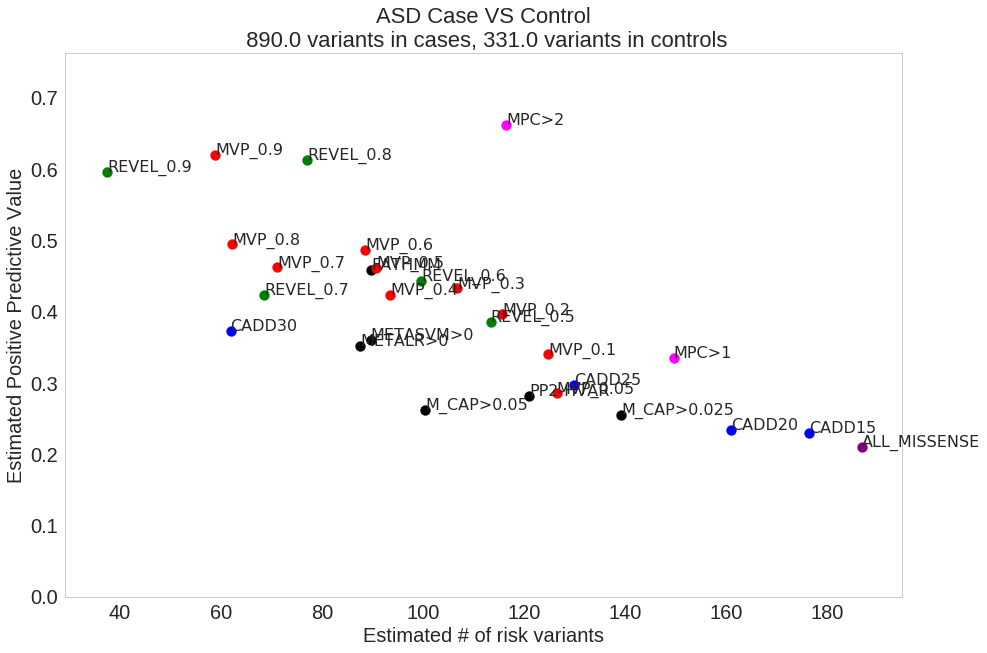

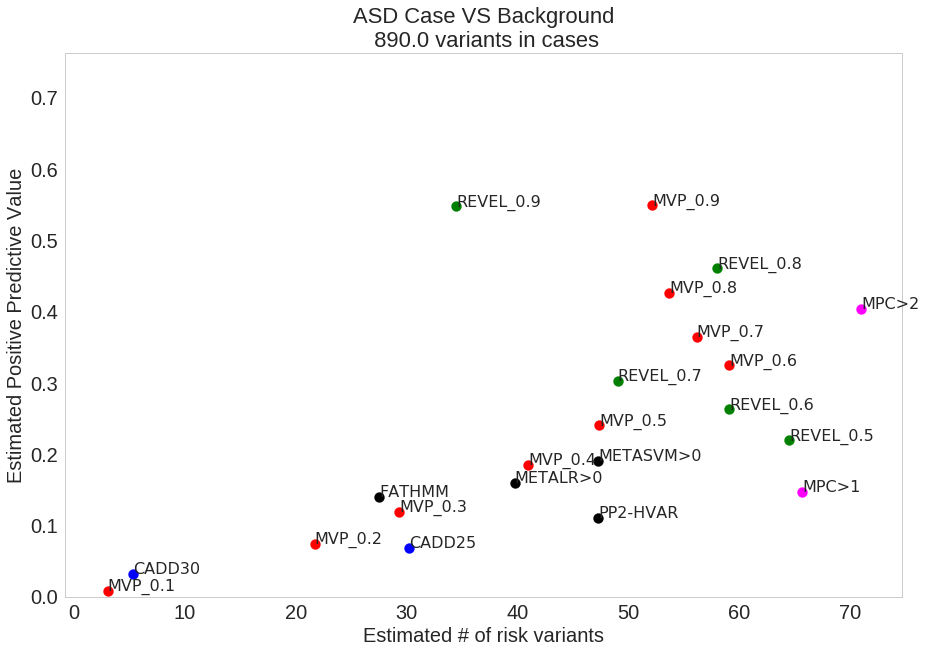

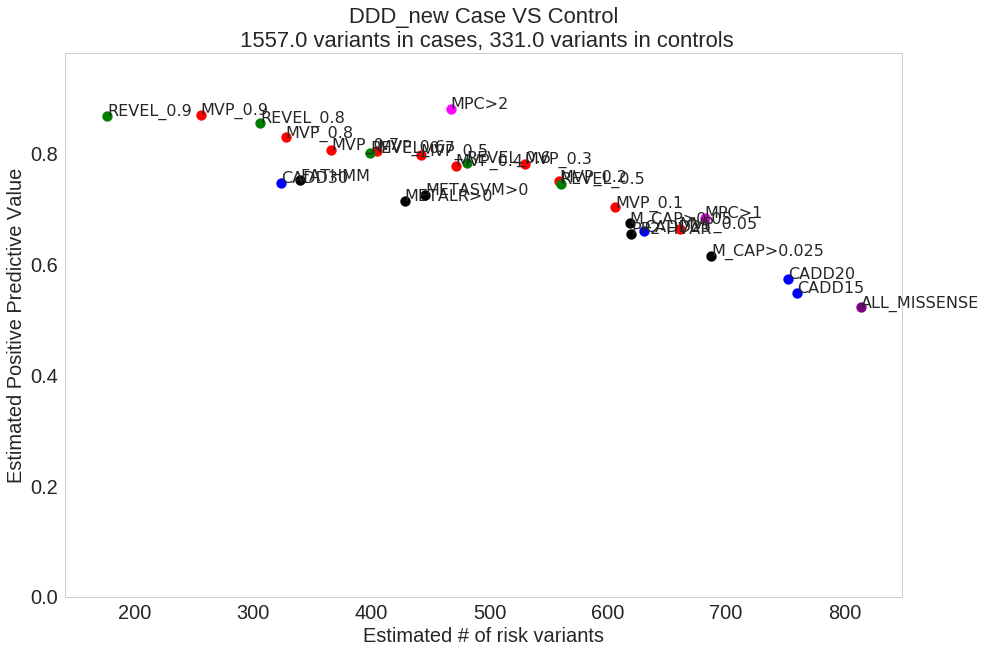

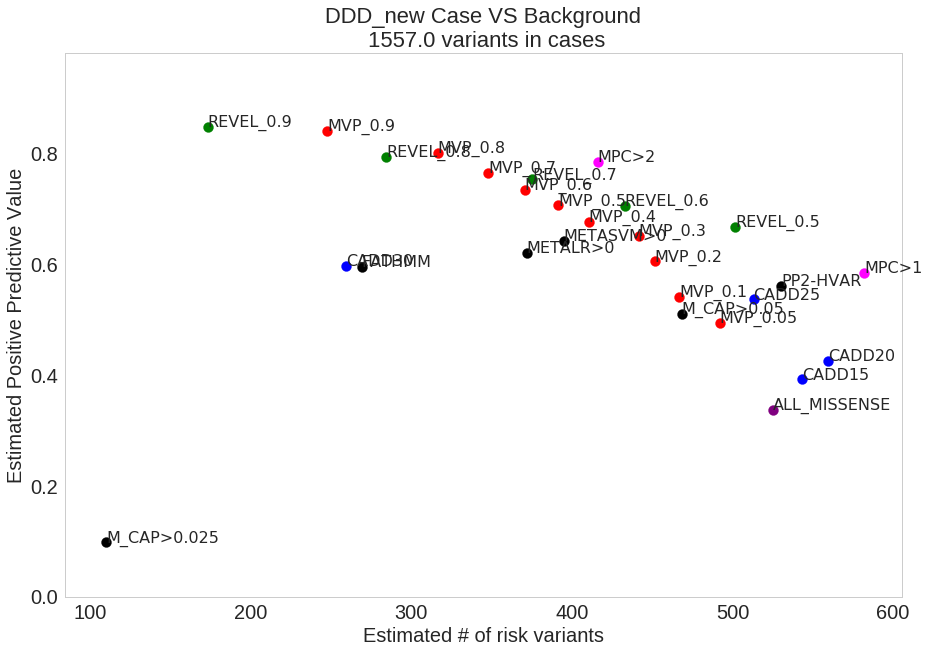

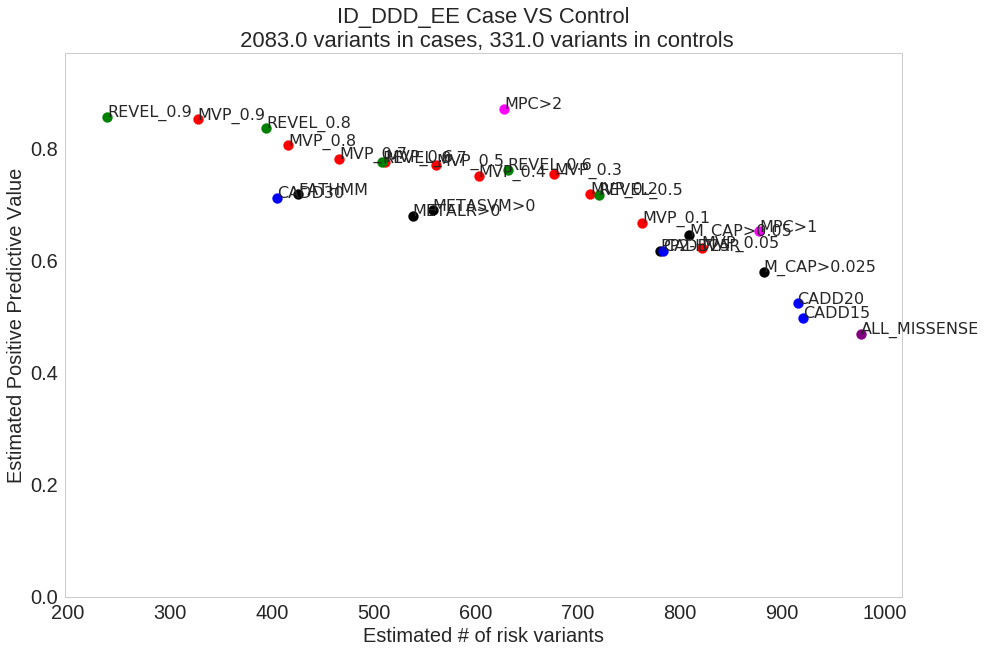

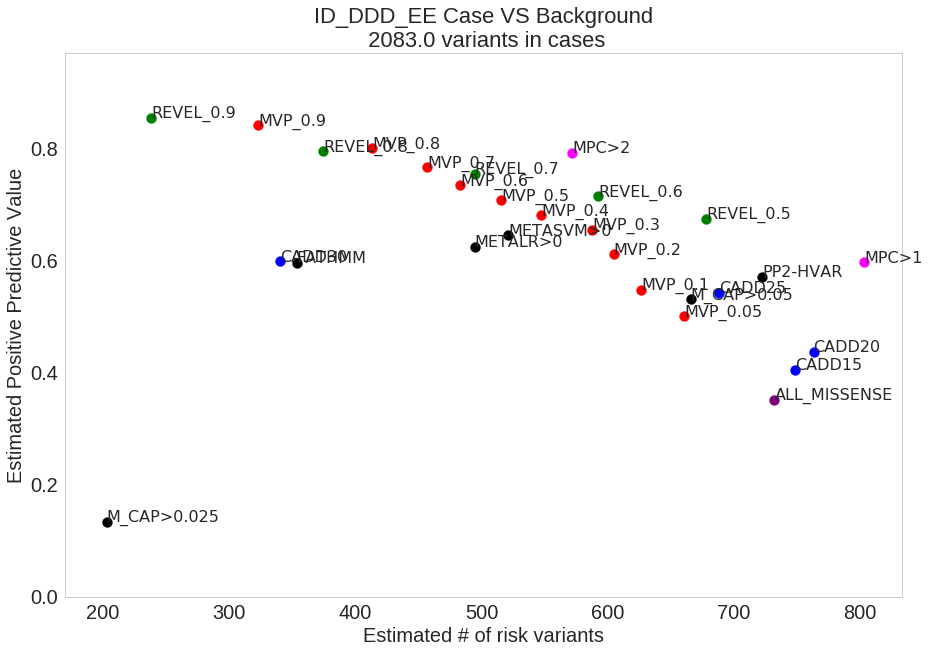

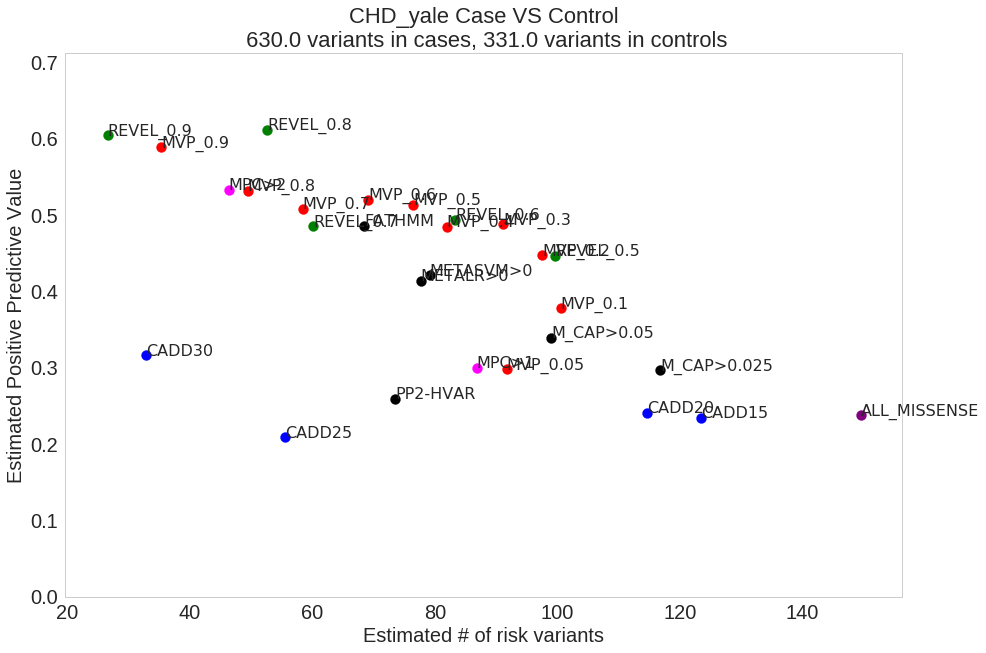

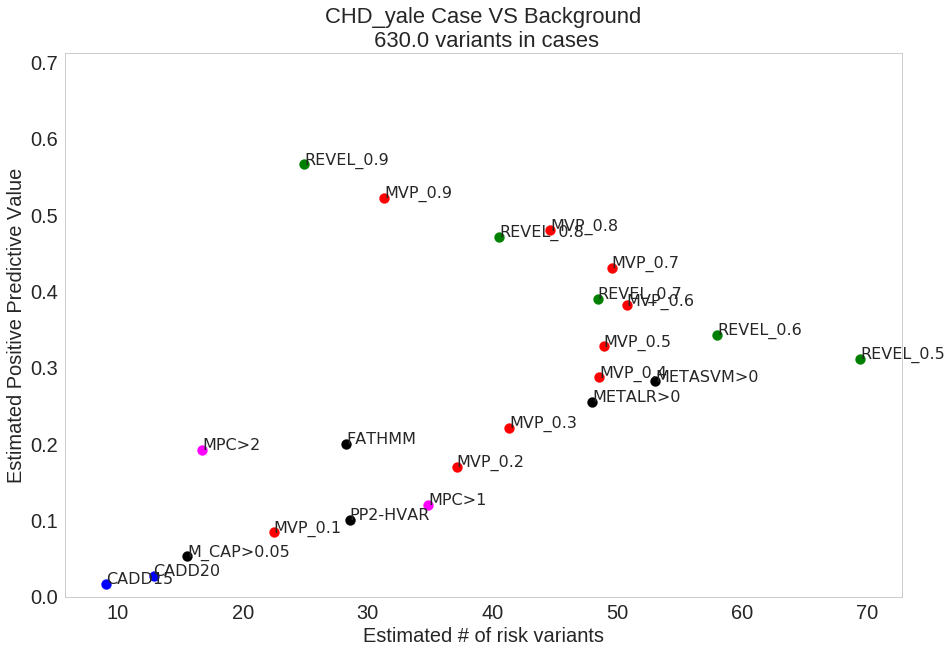

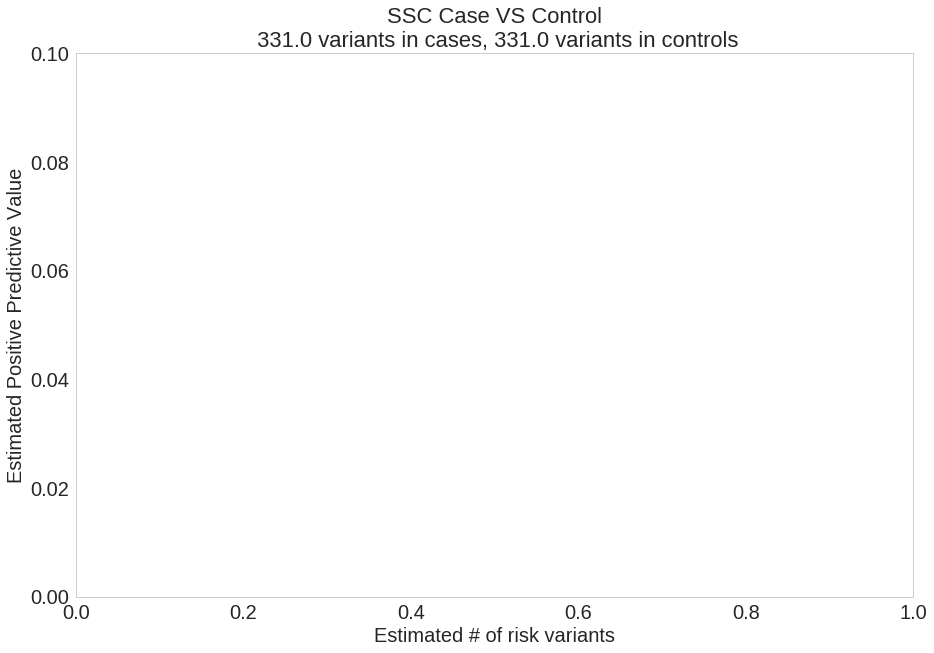

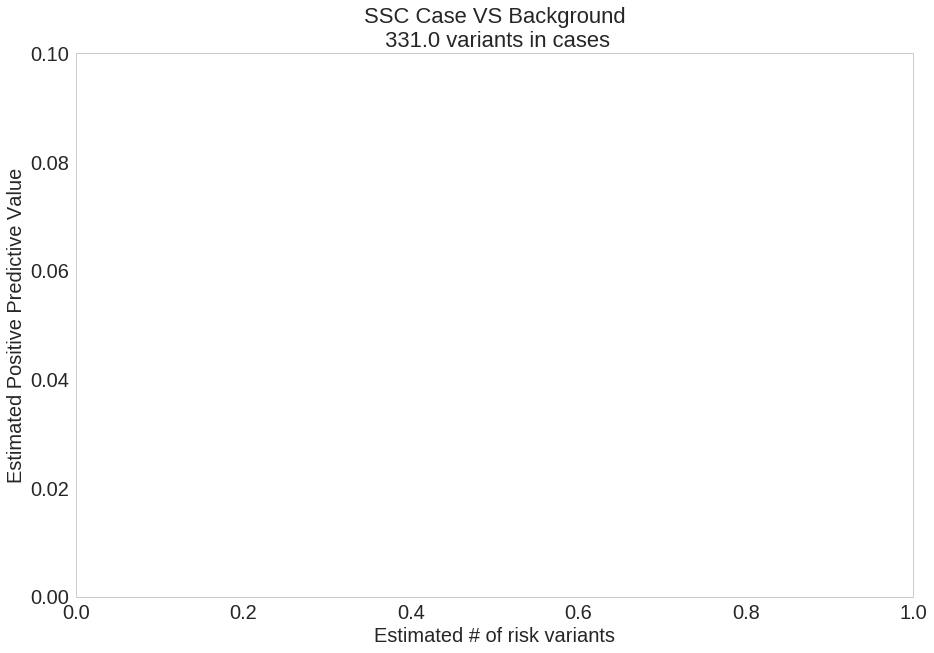

In [34]:
disease_size = {'CHD':2779, 'CDH':357,'CDH_MGH':80,
                'ASD':3953, 'EE':264, 'ID':192,
                'DDD_new':4293, 'DDD':1133, 'SSC':1911,
                'CHD_yale':2645, 'SSC_yale':1789,
                'ID_DDD_EE':5620,
                'control':2078} 

#fname = '../data/case_control/ssc_yale.anno.rare.'+prefix+'reformat.cnn.csv'
#control_disease = ['SSC_yale']
#syn_ratio = {'CHD_yale':1.0,'ASD':1.0 ,'DDD_new':1.0,'ID_DDD_EE':1.0,'CDH':1.0} 

fname = '../data/case_control/control_1911.anno.rare.'+prefix+'reformat.cnn.csv'
control_disease = ['SSC']
syn_ratio = {'CHD_yale':1.04859,'ASD':1.02691,'DDD_new':0.99904,'ID_DDD_EE':1.13627,'CDH':1.196931
             ,'SSC':1} # vs 1911control & bg rate

#fname = '../data/case_control/control_MarkDaly.anno.rare.'+prefix+'reformat.cnn.csv'
#control_disease = ['control']
#syn_ratio = {'CHD_yale':1.05101,'ASD':1.02928,'DDD_new':1.001342,'ID_DDD_EE':1.13889,'CDH':1.199692} # vs MDcontrol

#syn_ratio = {'CHD_yale':1.0,'ASD':1.0 ,'DDD_new':1.0,'ID_DDD_EE':1.0}
#syn_ratio = {'CHD_yale':1.0,'ASD':1.0 ,'DDD_new':1.0,'ID_DDD_EE':1.0,'CDH':1.0} #no CDH ratio
#syn_variant_num = {'CHD_yale':701,'ASD':1026,'DDD_new':1084,'control':524} # vs MDcontrol


df_control = pd.read_csv(fname)
index = df_control['disease'].isin(control_disease) & df_control['genename'].isin(geneset) 
#index = index & (df_control['prec'] >=0.8)

df_control = df_control[index]
control_info = (df_control, control_disease, disease_size)



# data is a little more than ANNOVAR annotatoin, do a comparison later
#case_diseases = [['CHD'], ['CDH'], ['ASD'],['EE'], ['ID'], ['DDD'], 
#                 ['CHD', 'CDH', 'ASD','EE', 'ID', 'DDD']]

case_diseases = [ ['ASD']]

for case_disease in case_diseases:
    

    fname = '../data/case_control/case.anno.rare.'+prefix+'reformat.cnn.csv'
    df_case = pd.read_csv(fname)
    index = df_case['disease'].isin(case_disease) & df_case['genename'].isin(geneset) 
    
    df_case = df_case[index]
    case_info = (df_case, case_disease, disease_size)
    df = display_enrichment(case_info, control_info, case_disease, geneset)
    #df.to_csv('../'+folder_prefix+'_enrich_figure/'+prefix+case_disease[0]+'.csv', sep='\t')

fname = '../data/case_control/DDD_new_0.2.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['DDD_new']
#print syn_ratio[case_disease[0]]

df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)
#df.to_csv('../'+folder_prefix+'_enrich_figure/'+prefix+case_disease[0]+'.csv', sep='\t')


fname = '../data/case_control/case_MarkDaly.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['ID_DDD_EE']
df_case = pd.read_csv(fname)
index = df_case['genename'].isin(geneset)    
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)
#df.to_csv('../'+folder_prefix+'_enrich_figure/'+prefix+case_disease[0]+'.csv', sep='\t')


fname = '../data/case_control/chd_yale.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['CHD_yale']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)
#df.to_csv('../'+folder_prefix+'_enrich_figure/'+prefix+case_disease[0]+'.csv', sep='\t')


# fname = '../data/case_control/CDH_mis.rare.'+prefix+'reformat.cnn.csv'
# case_disease = ['CDH']
# df_case = pd.read_csv(fname)
# index =  df_case['genename'].isin(geneset) 
# df_case = df_case[index]
# case_info = (df_case, case_disease, disease_size)
# df = display_enrichment(case_info, control_info, case_disease, geneset)

# this is the comparison between controls
fname = '../data/case_control/control_1911.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['SSC']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)

# case control enrichment line

In [35]:
import bisect
from statsmodels.stats.proportion import proportion_confint

def display_enrichment2(case_info, control_info, case_disease):
    
    print case_disease
    df_case, case_disease, disease_size = case_info 
    df_control, control_disease, disease_size = control_info 
    
    case_size = 0.0
    for disease in case_disease:
        if disease in disease_size:
            case_size += disease_size[disease]
    control_size = 0.0
    for disease in control_disease:
        control_size += disease_size[disease]
    print 'case size:{} control size:{}'.format(case_size, control_size)
    
    cols = ['CADD_phred', 'cnn_prob', 'MPC', 'REVEL']
    tpr, riskg, lower_riskg, upper_riskg = [], [], [], []
    for col in cols:
        tpr_lst, riskg_lst, lower_riskg_lst, upper_riskg_lst = get_enr_line(
            df_case, case_size, df_control, control_size, col)
        
        tpr.append(tpr_lst)
        riskg.append(riskg_lst)
        lower_riskg.append(lower_riskg_lst)
        upper_riskg.append(upper_riskg_lst)
        
    title = ''
    plot_rate_vs_riskvariants2(cols, tpr, riskg, lower_riskg, upper_riskg, title)

def get_enr_line(df_case, case_size, df_control, control_size, col):
    
    tpr_lst, riskg_lst, lower_riskg_lst,  upper_riskg_lst = [], [], [], []
    
    index = (df_case[col].notnull()) & (df_case[col]!= -1) & (df_case[col]!= 0)
    case_scores = sorted(df_case.ix[index][col].values)
    case_total = len(case_scores)
    
    index = (df_control[col].notnull()) & (df_control[col]!= -1) & (df_control[col]!= 0)
    control_scores = sorted(df_control.ix[index][col].values)
    control_total = len(control_scores)
    
    threshold = np.unique(case_scores + control_scores)
    min_thres, max_thres = min(threshold), max(threshold)
    threshold = np.arange(min_thres, max_thres, (max_thres - min_thres)/50)
    
    for thres in threshold:
        case_count = case_total - bisect.bisect_right(case_scores, thres)
        control_count = control_total - bisect.bisect_right(control_scores, thres)
        
        if control_count != 0:
            enrich = float(case_count) / case_size / (float(control_count) / control_size)
            if enrich > 1:
                tpr = (enrich - 1) / enrich
                risk_gene = case_count * tpr
                
                case_lower, case_upper = binomial_ci(case_count, control_count)
                total_counts = case_count + control_count
                n_risk_lower = case_lower - (total_counts - case_lower) * (case_size / control_size)
                n_risk_upper = case_upper - (total_counts - case_upper) * (case_size / control_size)

                tpr_lst.append(tpr)
                riskg_lst.append(risk_gene)
                lower_riskg_lst.append(n_risk_lower)
                upper_riskg_lst.append(n_risk_upper)
                
    return tpr_lst, riskg_lst, lower_riskg_lst, upper_riskg_lst
    
def plot_rate_vs_riskvariants2(cols, tpr, riskg, lower_riskg, upper_riskg, title):
    
    colors = {'CADD_phred':'yellow', 'cnn_prob':'red', 'MPC':'blue', 'REVEL':'green'}
    fig, ax = plt.subplots(figsize = (15,10))
    for c, t, r, l_r, u_r, in zip(cols, tpr, riskg, lower_riskg, upper_riskg):
        ax.plot(t, r, label=c, color=colors[c])
        ax.plot(t, l_r, linestyle=':', color=colors[c])
        ax.plot(t, u_r, linestyle=':', color=colors[c])
        
    ax.legend()

def binomial_ci(case, control):
    """calculte the confidence interval of case counts based on CI of p, 
    used beta method(similar outcomet as R, binomial_test method does not work well for input(2, 9))

    Parameters
    ----------
    case : int
        number of case counts
    control : int
        number of control counts

    Returns 
    -------
    lower_ci : int
    upper_ci : int
    """
    total = case + control
    lower_p, upper_p = proportion_confint(
        case, total, alpha=0.05, method='beta')
    lower_ci = total * lower_p
    upper_ci = total * upper_p
    return lower_ci, upper_ci

['ASD']
case size:3953.0 control size:1911.0
['DDD_new']
case size:4293.0 control size:1911.0
['ID_DDD_EE']
case size:5620.0 control size:1911.0
['CHD_yale']
case size:2645.0 control size:1911.0


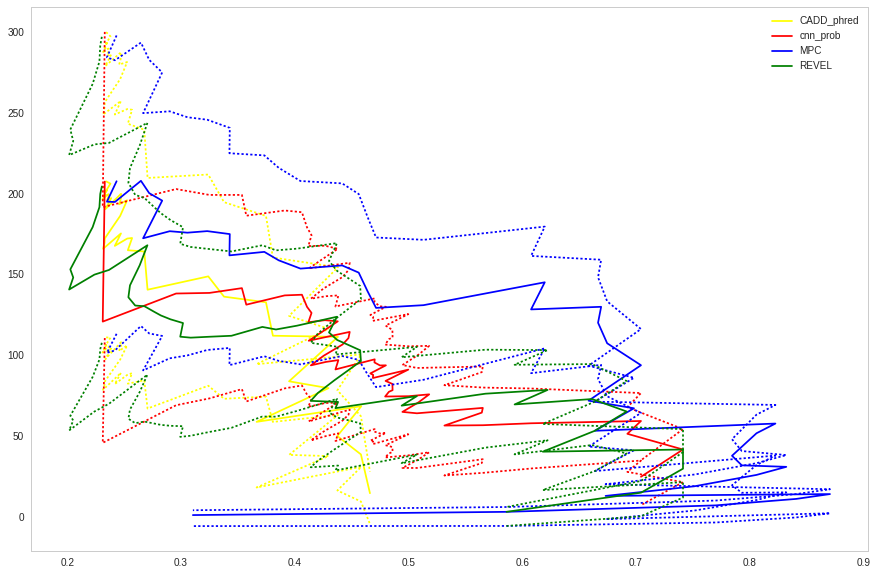

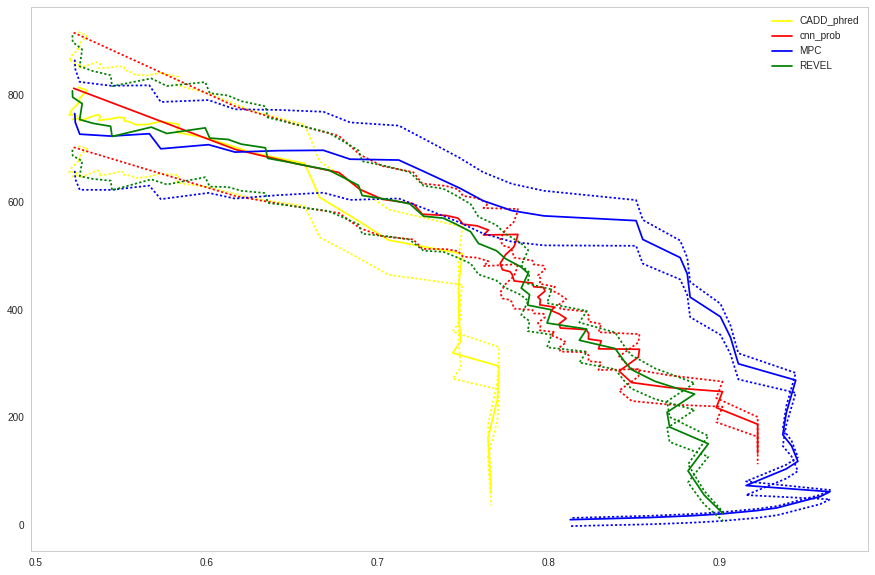

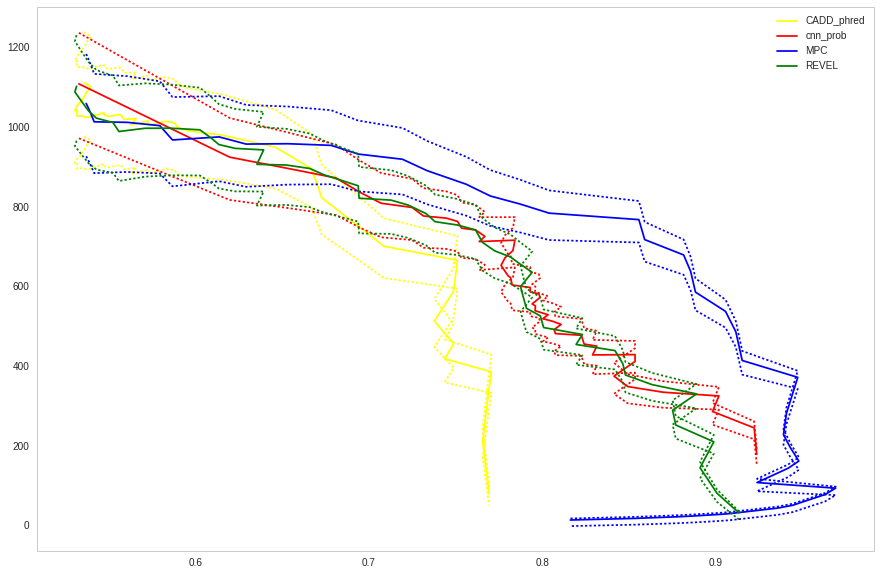

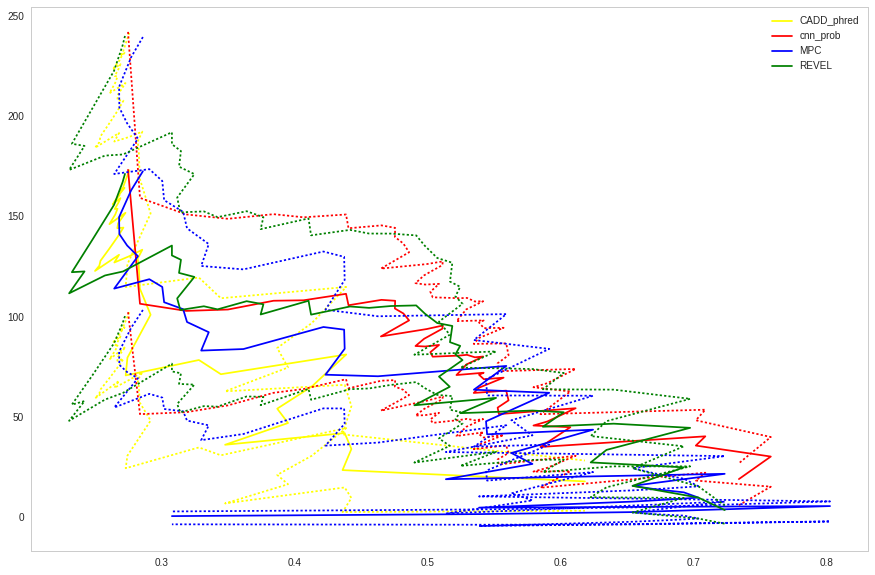

In [36]:
case_diseases = [ ['ASD']]

for case_disease in case_diseases:

    fname = '../data/case_control/case.anno.rare.'+prefix+'reformat.cnn.csv'
    df_case = pd.read_csv(fname)
    index = df_case['disease'].isin(case_disease) & df_case['genename'].isin(geneset) 
    
    df_case = df_case[index]
    case_info = (df_case, case_disease, disease_size)
    df = display_enrichment2(case_info, control_info, case_disease)


fname = '../data/case_control/DDD_new_0.2.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['DDD_new']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment2(case_info, control_info, case_disease)

fname = '../data/case_control/case_MarkDaly.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['ID_DDD_EE']
df_case = pd.read_csv(fname)
index = df_case['genename'].isin(geneset)    
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment2(case_info, control_info, case_disease)

fname = '../data/case_control/chd_yale.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['CHD_yale']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment2(case_info, control_info, case_disease)    